[[ 0. 24. 34. 41. 63. 64. 61. 44. 53.]
 [24.  0. 33. 36. 57. 58. 53. 48. 47.]
 [34. 33.  0. 29. 46. 47. 42. 32. 51.]
 [41. 36. 29.  0. 34. 35. 27. 47. 45.]
 [63. 57. 46. 34.  0.  4. 26. 57. 45.]
 [64. 58. 47. 35.  4.  0. 27. 57. 46.]
 [61. 53. 42. 27. 26. 27.  0. 60. 50.]
 [44. 48. 32. 47. 57. 57. 60.  0. 49.]
 [53. 47. 51. 45. 45. 46. 50. 49.  0.]]
q_matrix started!
q_matrix done!
q_matrix collated!
q_matrix started!
q_matrix done!
q_matrix collated!
q_matrix started!
q_matrix done!
q_matrix collated!
q_matrix started!
q_matrix done!
q_matrix collated!
q_matrix started!
q_matrix done!
q_matrix collated!
q_matrix started!
q_matrix done!
q_matrix collated!
q_matrix started!
q_matrix done!
q_matrix collated!
q_matrix started!
q_matrix done!
q_matrix collated!
q_matrix started!
q_matrix done!
q_matrix collated!
q_matrix started!
q_matrix done!
q_matrix collated!
q_matrix started!
q_matrix done!
q_matrix collated!
q_matrix started!
q_matrix done!
q_matrix collated!
q_matrix started!
q_matr

<Figure size 1500x1000 with 0 Axes>

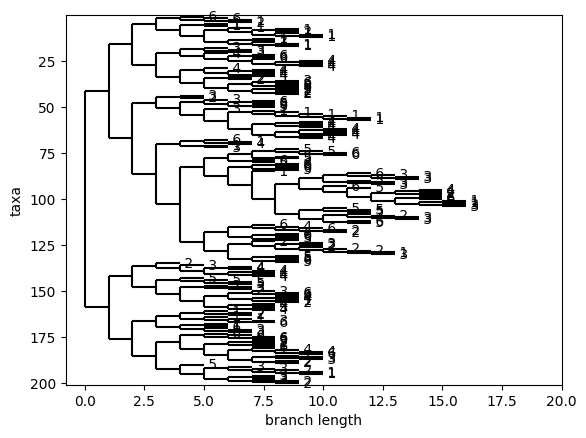

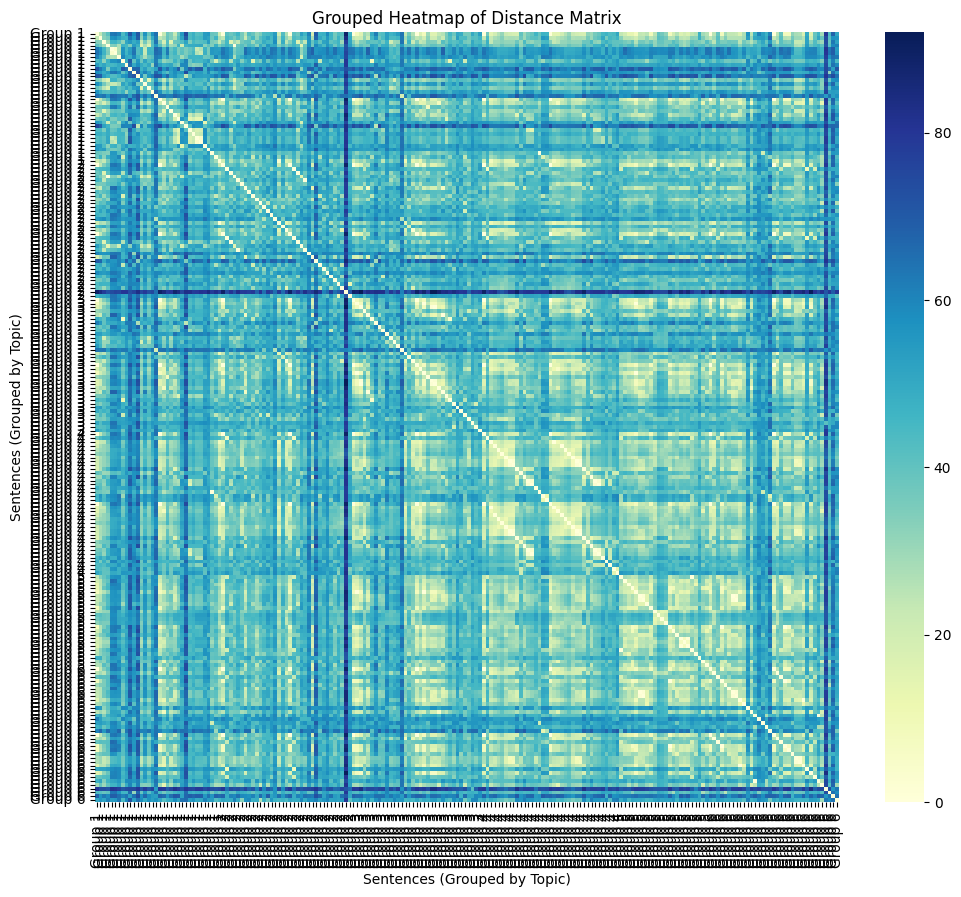

Current grouping entropy:  -0.40619040140324164


In [49]:
!pip install biopython
import json
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
from Bio import Phylo
from io import StringIO
import seaborn as sns


file_path = '/content/clusters_dataset.json'
with open(file_path, 'r') as f:
    data = json.load(f)

embeddings_file_path = '/content/clusters_dataset_embeddings.json'
with open(embeddings_file_path, 'r') as f:
    emb_data = json.load(f)

def extract_strings_with_labels(nested_structure, parent_key=""):
    strings = []
    if isinstance(nested_structure, dict):
        for key, value in nested_structure.items():
            new_key = f"{parent_key}/{key}" if parent_key else key
            strings.extend(extract_strings_with_labels(value, new_key))
    elif isinstance(nested_structure, list):
        for item in nested_structure:
            strings.append((item, parent_key))
    return strings

#extract data
strings_with_labels = extract_strings_with_labels(data)
strings_full = [s[0] for s in strings_with_labels]
labels_full = [s[1] for s in strings_with_labels]

emb_result = np.array(extract_strings_with_labels(emb_data), dtype="object")
sentence_full = []
weight_full = []
label_full = []
for entry in emb_result:
    sentence_full.append(entry[0][0])
    weight_full.append(entry[0][1])
    label_full.append(entry[1])

strings = strings_full[:200]
labels = labels_full[:200]

# Map topics to group numbers
unique_topics = sorted(set(labels))
topic_to_group = {topic: f"Group {i + 1}" for i, topic in enumerate(unique_topics)}
grouped_labels = [topic_to_group[label] for label in labels]

# Step 1: Compute the distance matrix using edit distance
def edit_distance(s1, s2):
    len_s1, len_s2 = len(s1), len(s2)
    dp = np.zeros((len_s1 + 1, len_s2 + 1), dtype=int)

    for i in range(len_s1 + 1):
        dp[i][0] = i
    for j in range(len_s2 + 1):
        dp[0][j] = j

    for i in range(1, len_s1 + 1):
        for j in range(1, len_s2 + 1):
            cost = 0 if s1[i - 1] == s2[j - 1] else 1
            dp[i][j] = min(
                dp[i - 1][j] + 1,       # Deletion
                dp[i][j - 1] + 1,       # Insertion
                dp[i - 1][j - 1] + cost # Substitution
            )

    return dp[len_s1][len_s2]

#calculate euclidena mat
def calculate_Euclidian(s1, s2):
  len_s1, len_s2 = len(s1), len(s2)
  Euc = np.zeros((len_s1, len_s2))
  s1 = np.array(s1)
  s2 = np.array(s2)
  for i in range(len_s1):
    for j in range(len_s2):
      Euc[i][j] = np.sqrt(np.sum((s2[j] - s1[i]) ** 2))

  return Euc

Euc_distance_mat = calculate_Euclidian(weight_full[:200], weight_full[:200])

if len(strings) < 3:
    raise ValueError("Neighbor joining requires at least three strings in the dataset.")

# Step 1: Compute the distance matrix in parallel
def compute_dist_matrix(strings, edit_distance):
    n = len(strings)
    dist_matrix = np.zeros((n, n))

    def compute_distance(i, j):
        return edit_distance(strings[i], strings[j])

    # Parallel computation of upper triangle of the distance matrix
    results = Parallel(n_jobs=-1)(
        delayed(compute_distance)(i, j) for i in range(n) for j in range(i + 1, n)
    )

    k = 0
    for i in range(n):
        for j in range(i + 1, n):
            dist_matrix[i, j] = results[k]
            dist_matrix[j, i] = results[k]
            k += 1
    return dist_matrix

dist_matrix = compute_dist_matrix(strings, edit_distance)
print(dist_matrix[:9, :9])

# Step 2: Parallelize Q-matrix computation
class NeighborJoining:
    def __init__(self, dist_matrix, labels):
        self.dist_matrix = dist_matrix
        self.labels = labels
        self.n = len(labels)

    def compute_q_matrix(self):
        n = self.n
        q_matrix = np.full((n, n), np.inf)

        def compute_q(i, n, dist_matrix):
            res = list()
            for j in range(i + 1, n):
                res.append((i, j,  (n - 2) * dist_matrix[i, j] - np.sum(dist_matrix[i, :]) - np.sum(dist_matrix[:, j])))
            return res

        print('q_matrix started!')
        results_batch = Parallel(n_jobs=-1)(
            delayed(compute_q)(i, n, self.dist_matrix.copy()) for i in range(n)
        )
        print('q_matrix done!')
        results = list()
        for batch in results_batch:
            results.extend(batch)

        for i, j, dij in results:
            q_matrix[i, j] = dij
            q_matrix[j, i] = dij
        print('q_matrix collated!')
        return q_matrix

    def find_min_q(self, q_matrix):
        return np.unravel_index(np.argmin(q_matrix), q_matrix.shape)

    def update_distance_matrix(self, i, j):
        new_distances = []
        for k in range(self.n):
            if k != i and k != j:
                new_dist = (self.dist_matrix[i, k] + self.dist_matrix[j, k] - self.dist_matrix[i, j]) / 2
                new_distances.append(new_dist)
        new_dist_matrix = np.delete(self.dist_matrix, [i, j], axis=0)
        new_dist_matrix = np.delete(new_dist_matrix, [i, j], axis=1)
        new_dist_matrix = np.vstack([new_dist_matrix, new_distances])
        new_distances.append(0)
        new_dist_matrix = np.hstack([new_dist_matrix, np.array(new_distances).reshape(-1, 1)])
        return new_dist_matrix

    def build_tree(self):
        labels = self.labels[:]
        while len(labels) > 2:
            q_matrix = self.compute_q_matrix()
            i, j = self.find_min_q(q_matrix)
            new_label = f"({labels[i]},{labels[j]})"
            labels.append(new_label)
            self.dist_matrix = self.update_distance_matrix(i, j)
            labels.pop(max(i, j))
            labels.pop(min(i, j))
            self.n -= 1
        return f"({labels[0]},{labels[1]})"

# Run Neighbor Joining with parallelized distance matrix and Q-matrix computation
# Euc_distance_mat
distance_mat_final = Euc_distance_mat + dist_matrix
nj = NeighborJoining(distance_mat_final, grouped_labels)
phylogenetic_tree = nj.build_tree()
print("Phylogenetic Tree (Newick Format):", phylogenetic_tree)

# Visualize the Tree using Bio.Phylo
plt.figure(figsize=(15, 10))
handle = StringIO(phylogenetic_tree)

#get entropy and leaf groups
tree = Phylo.read(handle, "newick")
root_node = tree.root.name

leaf_nodes = [leaf.name for leaf in tree.root.get_terminals()]
lev1_nodes = [child.name for child in tree.root.clades]

#total numebr of leaves
total = len(tree.root.get_terminals())

group = []
for child in tree.root.clades:
  for lev2 in child.clades:
    group.append(lev2)
print(group)

Entropy = []

for sub_root in group:
  leave_nodes = [leav.name for leav in sub_root.get_terminals()]

  Cur_Entropy = (leave_nodes.count('1') / len(leave_nodes) * np.log2(leave_nodes.count('1') / len(leave_nodes)) if leave_nodes.count('1') != 0 else 0)
  + (leave_nodes.count('2') / len(leave_nodes) * np.log2(leave_nodes.count('2') / len(leave_nodes)) if leave_nodes.count('2') != 0 else 0)
  + (leave_nodes.count('3') / len(leave_nodes) * np.log2(leave_nodes.count('3') / len(leave_nodes)) if leave_nodes.count('3') != 0 else 0)
  + (leave_nodes.count('4') / len(leave_nodes) * np.log2(leave_nodes.count('4') / len(leave_nodes)) if leave_nodes.count('4') != 0 else 0)
  + (leave_nodes.count('5') / len(leave_nodes) * np.log2(leave_nodes.count('5') / len(leave_nodes)) if leave_nodes.count('5') != 0 else 0)
  + (leave_nodes.count('6') / len(leave_nodes) * np.log2(leave_nodes.count('6') / len(leave_nodes)) if leave_nodes.count('6') != 0 else 0)

  Entropy.append(Cur_Entropy * (len(leave_nodes) / total))
print(sum(Entropy))



Phylo.draw(tree, label_func=lambda x: x.name.split('/')[-1] if x.name else x.name)
plt.show()

# Grouped Heatmap
sorted_indices = sorted(range(len(grouped_labels)), key=lambda i: grouped_labels[i])
sorted_dist_matrix = dist_matrix[np.ix_(sorted_indices, sorted_indices)]
sorted_labels = [grouped_labels[i] for i in sorted_indices]

plt.figure(figsize=(12, 10))
sns.heatmap(
    sorted_dist_matrix,
    xticklabels=sorted_labels,
    yticklabels=sorted_labels,
    cmap="YlGnBu",
    annot=False
)
plt.title("Grouped Heatmap of Distance Matrix")
plt.xlabel("Sentences (Grouped by Topic)")
plt.ylabel("Sentences (Grouped by Topic)")
plt.show()

print("Current grouping entropy: ", sum(Entropy))